# Deep Learning Part 2: Modules and the Training Pipeline

## Grading Standards:
* Intro (10%)
* Linear regression (60%)
    * Module (10%)
    * Linear layer (20%)
    * SGD, MSE (10%)
    * Train (20%)
* Non-linear regression (30%)
    * Stacked linear (10%)
    * Deep network (10%)
    * Sequential (10%)
___

In this lab, we will be utilizing PyTorch modules to create neural networks, which we will use to solve a simple nonlinear regression problem. This will guide you through the deep learning training and validation loops which you will use in some form in every deep learning project.

In [ ]:
import torch
import torch.nn as nn # Contains torch modules (network layers)
import torch.nn.functional as F # Contains stateless functional versions of modules

import matplotlib.pyplot as plt

In order to have reproducible results, we'll set the random seed. Because cells in notebooks can be run in any order, we'll need to set the seed multiple times: whenever the cell uses random operations. If you were to run your code in a script, you could just set the seed at the top.

In [ ]:
torch.manual_seed(0) # Sets random seed for all PyTorch operations

---
### GPUs and Cuda
Generally, as programmers, we run everything on the CPU.
CPUs are designed to perform all sorts of calculations, but they are very slow for linear algebra tensor operations.
The GPU was designed to perform efficient math on large tensors (originally for rendering graphics).
Because deep learning is all tensor math, we can use the GPU to speed up our networks!
While you can do all labs on the CPU, training and validation will be very slow, so we recommend using the GPU.

Cuda is the library used to interact with Nvidia GPUs.
Google Colab and Kaggle offer free GPU usage (with some limitations) if you don't have a CUDA-compatible GPU.

**To use the GPU on Colab go to 'Runtime' at the top and then click 'Change runtime type'.**
Execute the cell below and make sure cuda is available.

In [ ]:
print(f"Cuda is available: {torch.cuda.is_available()}")

We can check to see what device (`cpu` or `cuda`) a tensors is on by looking at its `.device` variable.
Go ahead a print out what device `a` is on.

In [ ]:
a = torch.tensor(1)

# TODO: print out a's device.


By default all tensors start on the CPU.
To put a device on the GPU you can use the `.cuda()` function. Go ahead and put `a` on the GPU by using `a = a.cuda()` and print out the device.

*Note: `.cuda()` returns a COPY of the tensor so assignment is necessary.*

In [ ]:
# TODO: Put `a` on the GPU.

assert str(a.device) == 'cuda:0'

Now that our tensor is on the GPU, every operation we perform with it will be on the GPU and the resulting tensors will also be on the GPU.

In [ ]:
b = a+1
print(b)

PyTorch makes using the GPU easy and almost invisible. This makes it easy to forget which device your tensor is on.

You can only perform tensor operations with tensors on the same device. If you try to do an operation between tensors on the CPU and GPU (or between different GPUs) you will get the following error:

In [ ]:
# NOTE: This code SHOULD throw an error (if cuda is available)
b_cpu = torch.ones(1)
b_gpu = torch.ones(1).cuda()
print('Adding two tensors on the GPU gives us a GPU tensor:')
print(a + b_gpu)
print('Adding two tensors on different devices gives us this error:')
print(a + b_cpu)

If you want to put a tensor back on the CPU you can use the `.cpu()` function. Go ahead and put `a` on the CPU and print out the device.

*Note: `.cpu()` returns a COPY of the tensor so assignment is necessary.*

In [ ]:
# TODO: Put `a` on the CPU.

assert str(a.device) == "cpu"

Only PyTorch operates on the GPU. Some operations, like printing the tensor, automatically copies the tensor on the CPU, but others, like `.numpy()` can't work unless the tensor is already on the CPU.

In [ ]:
print('CPU tensor to NumPy works:')
print(a.cpu().numpy())
print('GPU tensor to NumPy fails:')
print(a.cuda().numpy())

You can also put a tensor on a device using the `.to()` function.
First create a cuda `device` object with `device = torch.device('cuda')` (You can similarly create a cpu device with `torch.device('cpu')`).
Then set `a = a.to(device)`.

In [ ]:
# TODO: Create a cuda device
device = None

# TODO: Set a to device

assert 'cuda' in str(a.device)

This is the best way to set tensors to a device since sometimes you may want to switch from being on the GPU to the CPU, for debugging purposes, and now instead of manually changing all `.cuda()` to `.cpu()` you just need to change the global variable `device` to be a `torch.device('cpu')` and all of your code will work automatically.

Pay close attention to what devices your tensors are on and you will avoid a lot of errors.

---

## Plotting Helper Functions

In [ ]:
# Plots each (x,y) point, a prediction if a network is provided, and the ground-truth function if provided
def plot_data(x, y, network=None, gt_func=None, title=''):
    plt.plot(x, y, marker='.', linewidth=0, color='black') # plots the real points
    if network is not None:
        dense_x = torch.linspace(x.min(), x.max(), 1000).unsqueeze(1) # Evenly-spaced predicted x values
        with torch.no_grad(): # this will be explained in the `validation` function
            y_hat = network(dense_x.to(device)).cpu() # non-pytorch libraries like matplotlib need tensors to be on the CPU!
        plt.plot(dense_x, y_hat, label='network prediction')

        if gt_func is not None:
            plt.plot(dense_x, gt_func(dense_x), label='true function')
            plt.legend()

    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def plot_loss(losses, title=''):
    plt.plot(losses)
    plt.xlabel("training step")
    plt.ylabel("MSE loss")
    plt.title(title)
    plt.show()

---

# Linear Regression

You will now solve a linear regression problem, like in lab 1.
If you recall from lab 1, solving a regression problem involved multiple iterations of the following steps:
1. Applying the slope formula, $Wx + b$, to get our predicted output
2. Getting our loss
3. Calling backward
4. Updating our slope and intercept tensors with their gradients

We will be doing the exact same thing, but we will now do it in a more PyTorch-specific way, using `torch.nn`.

PyTorch's neural network library `torch.nn` has lots of functionality for building neural networks.
There are two important classes in the `nn` library: `Parameter` and `Module`.
A `Parameter` is just a `Tensor` with a little extra functionality.
A `Module` is a class that can contains `Parameter`s (e.g. weights) and other `Module`s and performs a function on them through the `Module.forward()` function.
In PyTorch neural networks inherit the `Module` class and it will be composed of layers that also inherit `Module` class.

Let's build a dummy module below to see some of the functionality of a `Module` class.

In [ ]:
class DummyModule(nn.Module):
    def __init__(self):
        # TODO: It is VERY IMPORTANT you add `super().__init__()` to all nn.Module constructors you create.
        pass
        # TODO: Create a self.parameter1 variable with weights [1., 1.]. You can instantiate a `Parameter` by calling `nn.Parameter()` and passing a tensor inside.
        self.parameter1 = None
        # TODO: Create a self.parameter2 variable with weights [2., 2.].
        self.parameter2 = None

    def forward(self, x):
        # TODO: Add self.parameter1 to x and then multiply the result by self.parameter2 and return the output.
        pass

dummy = DummyModule()

Print out whether `dummy.parameter1` requires grad or not.

By default a `Parameter` has `.requires_grad` set to true.

Let's see the parameters in `dummy`; call `dummy.parameters()` and output its contents.

*Note: `.parameters()` returns a generator so in order to see its contents you need to either convert it to a list, e.g. `list()`, or iterate through it with a for loop.*

We can even view each parameter's name by calling `dummy.named_parameters()`. Call `dummy.named_parameters()` below and output its contents.

Now use the `.forward()` function, however do not call `.forward()` directly, instead you should use the `.__call__()` function.
PyTorch has extra functionality added in the `.__call__()` function, mainly adding hooks, and so you should **never** call `.forward()` directly.
Execute the cell below as an example of what we mean.

In [ ]:
class Foward_vs_Call_Example:
    def __call__(self, x):
        print('Do something important before .foward()')
        self.forward(x)
        print('Do something important after .forward()')

    def forward(self, x):
        print(f'forward function using {x}')

example = Foward_vs_Call_Example()
x = "tensor"

Call `example.forward()` and pass in `x`.

Now call `example.__call__()` and pass in `x`. You shouldn't explicitly write `example.__call__()`, running `example()` is the same as calling `example.__call__()`.

Using the `.__call__()` function, execute `DummyModule`'s `forward()` functionality to execute operations on tensors `a` and `b` below.

In [ ]:
a = torch.tensor([1., 1.])
b = torch.tensor([-1., 2.])

# TODO: Execute `DummyModule` forward on tensor a
answer = None

assert torch.equal(answer, torch.tensor([4., 4.]))

# TODO: Execute `DummyModule` forward on tensor b
answer = None

assert torch.equal(answer, torch.tensor([0., 6.]))

Another nice utility of a `Module` is that you can put all of its parameters on a device by using the `.to()` function.
Set `dummy = dummy.to(device)` and print out the devices that `parameter1` and `parameter2` are on to validate this is true.

Now that you understand the `Parameter` and `Module` classes a little better, build a linear layer `Module` (called `LinearLayer`) so we can do linear regression.
The `LinearLayer` will perform an affine transformation, i.e. $Wx + b$.
However, the shape of `x` will be `(B, Z_in)`, where `B` is the 'batch size' and `Z_in` is our 'input feature size' and the expected shape of our output is `(B, Z_out)`, where `B` is the 'batch size' and `Z_out` is the 'output feature size', therefore, your `LinearLayer` should perform $xW$ matrix multiplication, since $(B \times Z_{in}) \cdot (Z_{in} \times Z_{out}) \rightarrow (B \times Z_{out})$, to ensure that the batch size remains in the 0th dimension.

Follow the TODOs down below.

```python
class LinearLayer(nn.Module):
    def __init__(self, input_feature_size, output_feature_size):
        # TODO 1: It is VERY IMPORTANT you add `super().__init__()` to all nn.Module constructors you create.
        # TODO 2: Initialize a self.weight Parameter with shape (input_feature_size, output_feature_size)
        # TODO 3: Use the nn.init.xavier_uniform_() function to set the weights in the self.weight
        # TODO 4: Initialize a self.bias Parameter with shape (output_feature_size,)
        # TODO 5: Use the nn.init.uniform_() function to set the weights in the self.bias between -1 and 1

    def forward(self, x):
        # TODO: Implement the affine transformation Wx + b correctly and return the output
```

You can find helpful resources and documentation on `nn.init.xavier_uniform_()` and `nn.init.uniform_()` online.

*Note: In PyTorch a function that ends with '_' will perform the operation inplace.*

In [ ]:
class LinearLayer(nn.Module):
    def __init__(self, input_feature_size, output_feature_size):
        pass

    def forward(self, x):
        pass


Execute the code below to assert that your functionality works correctly.

In [ ]:
def test_LinearLayer():
    x = [[0, 0, 0],
         [1, 1, 1],
         [2, 2, 2],
         [0, 1, 2]]
    x = torch.tensor(x, dtype=torch.float32)

    batch_size, in_features = x.shape
    out_features = 2

    layer = LinearLayer(in_features, out_features)
    y = layer(x)
    assert y.shape == torch.Size([batch_size, out_features])

    layer.weight.data = torch.tensor([[2, 0],[0, 1], [1, 1]], dtype=torch.float32)
    layer.bias.data = torch.tensor([0, 1], dtype=torch.float32)

    y = layer(x)
    assert torch.equal(y, torch.tensor([[0, 1], [3, 3], [6, 5], [2, 4]]))

test_LinearLayer()

Now that we have `LinearLayer` built, let's create an `SGD` optimizer that will update the parameters in `LinearLayer`.

In [ ]:
class SGD:
    def __init__(self, parameters, lr):
        # TODO: Store the parameters. Note that parameters could either be a list of Tensors or a generator, so you should cast parameters as a list before setting it to self.parameters.
        pass
        # TODO: Store the learning rate.
        pass

    def zero_grad(self):
        """
        To avoid gradients from accumulating let zero_grad() zero out all the gradients in self.parameters
        """
        pass

    def step(self):
        """
        This is where you will take you gradient steps for each of your parameters.
        Remember to use '.data', subtract the gradients, and use your learning rate
        """
        pass


Execute the cell below to test that your implementation works correctly.

In [ ]:
def test_sgd():
    linear_layer = LinearLayer(1, 1)
    linear_layer.weight.data = torch.tensor([[1.]])
    linear_layer.weight.grad = torch.tensor([[.5]])

    linear_layer.bias.data = torch.tensor([0.])
    linear_layer.bias.grad = torch.tensor([1.])

    optimizer = SGD(linear_layer.parameters(), .1)

    # TESTING STEP
    optimizer.step()
    assert torch.equal(linear_layer.weight, torch.tensor([[.95]]))
    assert torch.equal(linear_layer.bias, torch.tensor([-.1]))

    # TESTING ZERO_GRAD
    optimizer.zero_grad()
    assert linear_layer.weight.grad is None or torch.equal(linear_layer.weight.grad, torch.zeros_like(linear_layer.weight.grad))
    assert linear_layer.bias.grad is None or torch.equal(linear_layer.bias.grad, torch.zeros_like(linear_layer.bias.grad))

test_sgd()

Finally, implement the loss function necessary to train our network. We will use mean squared error (MSE):
$$\textrm{MSE}(\hat{y}, y) = \frac{1}{\lvert y \rvert} \sum_{k=0}^{\lvert y \rvert - 1} (\hat{y}_k - y_k)^2$$

Do **not** use a for loop in your implementation, use `torch.mean()` instead.
You can use `nn.functional.mse_loss()` to validate your implementation works.

In [ ]:
def mse_loss(y_hat, y):
    pass

Now that we have the necessary components to learn linear regression, let's generate some data.

In [ ]:
torch.manual_seed(0)
# Creating a linear regression dataset
linear_x = (torch.rand(100, 1) - .5) * 10
linear_m = torch.randn(1)
linear_b = torch.randn(1)
linear_y = linear_m * linear_x + linear_b + torch.randn(100,1)*.01

print("True function: y = {:.4f}x + {:.4f}".format(linear_m.item(), linear_b.item()))

In [ ]:
plot_data(linear_x, linear_y, title="Linear Dataset")

Now implement the following training function.
There are two things to note:
1. Because the loss $L$ has gradient information attached (remember the computation graph), do not blindly append $L$, otherwise we will continually create thousands of computation graphs and the data will never be freed. While calling `L.detach()` would avoid this issue, since we only care about the loss value, call `L.item()` which will return the loss as a float.
2. Other than in the comments we do not explicitly mention the SGD optimizer. It is implicit and therefore, you can either pass in the optimizer or initialize it inside the training loop. Passing it in is the preferred method, so we will opt for that.


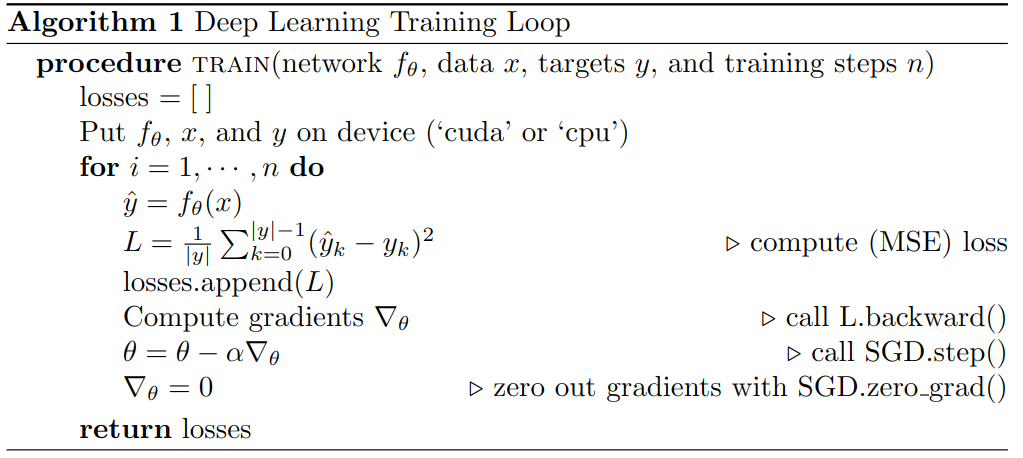

In [ ]:
def train(network, optimizer, x, y, training_steps):
    # TODO: Implement training loop
    pass


Now, we'll create a single-layer regression model. For the data to fit into the model, we must provide the correct `input_feature_size` parameter. For the prediction to match the true labels and fit into the loss function with the label, we must provide the correct `output_feature_size` parameter. In this case, we have a single x-value as an input and a single y-value as an output, so `input_feature_size=1` and `output_feature_size=1`.

Initialize a `LinearLayer` and a `SGD` optimizer (learning rate of .1) and train your network for 50 steps.

In [ ]:
# TODO: Initialize a LinearLayer
linear_network = None

# TODO: Initialize an SGD Optimizer with a learning rate of .1

# TODO: Train linear_network for 50 steps using your train function, store your training losses in `train_losses` for plotting
train_losses = None

plot_loss(train_losses, title="Loss on Linear Dataset")

Your loss plot should be decreasing in a curve: it decreases very quickly at first and starts to level off.

In [ ]:
# Plot your fit on the data
plot_data(linear_x, linear_y, linear_network, title="Linear Layer Fit on Linear Dataset")

### Nonlinear Regression

Some problems cannot be effectively solved by a linear model. We can create more complex nonlinear models by stacking linear layers and nonlinear activation functions.

Here, we have a nonlinear function we'd like to approximate. Try to solve it with a one-layer linear model.

In [ ]:
torch.manual_seed(0) # Sets random seed for all PyTorch operations
sine_x = torch.rand((100,1))*8 - 4
sine_y = torch.sin(sine_x) + torch.randn_like(sine_x)*.1 # the second part of the sum adds noise to the function

plot_data(sine_x, sine_y, title="Sine wave dataset")

Initialize a `LinearLayer` and a `SGD` optimizer (learning rate of .05) and train your network for 50 steps.

In [ ]:
# TODO: Initialize a LinearLayer
linear_network = None

# TODO: Initialize an SGD Optimizer with learning rate of .05

# TODO: Train linear_network for 50 steps using your train function, store your training losses in `train_losses` for plotting
train_losses = None

# Plot your losses
plot_loss(train_losses,"Linear Net Loss on Sine Dataset")

# Plot the fit on the dataset
plot_data(sine_x, sine_y, linear_network, gt_func=torch.sin, title="Linear Net Predictions on Sine Dataset")

In [ ]:
print("Our network's trained prediction function is:")
print("y = {:.3f}x + {:.3f}".format(linear_network.weight.data.item(), linear_network.bias.data.item()))

A linear network can only create a linear prediction, which isn't very useful for complex problems. Let's create a deeper network with multiple layers called `StackedLinear`.
`StackedLinear` should have 3 `LinearLayer`s:
- Layer 1 should map tensors from `(B, Z_in)` to `(B, H)` where `H` is the hidden size.
- Layer 2 should map tensors from `(B, H)` to `(B, H)`.
- Layer 3 should map tensors from `(B, H)` to `(B, Z_out)`.

In [ ]:
class StackedLinear(nn.Module):
    def __init__(self, input_feature_size, output_feature_size, hidden_size):
        #TODO: Create three linear layers called `self.lin1`, `self.lin2`, and `self.lin3`
        pass

    def forward(self, x):
        # TODO: Pass x through self.lin1
        # TODO: Pass the output of self.lin1 into self.lin2
        # TODO: Pass the output of self.lin2 into self.lin3 and return its output
        pass

To see some other functionality that a `Module` has, create a `StackedLinear` object called `stacked_net` and print out `stacked_net`

Printing out a `Module` is a simple way to see what the object contains.
Furthermore, `.parameters()` is recursive, so while we haven't define any `Parameter`s inside of `StackedLinear` because `LinearLayer` has some we get them when we call `.parameters()`.
Use `.named_parameters()` to print out the names of all the `Parameter`s in `stacked_net`.

Now we can try to solve the nonlinear problem with our stacked network.
Initialize a `StackedLinear` (with hidden size set to 64) and a `SGD` optimizer (learning rate of .01) and train your network for 50 steps.

The `input_feature_size` and `output_feature_size` should be the same as for our one-layer linear network, since they are problem-dependent not network-dependent. `hidden_size` is a hyperparameter and one that you choose the value of. It determines the size of the tensors created as the input passes through the network layers (except for the final layer), so a higher `hidden_size` means your network has more parameters and can learn more complex functions. However, it also means your network has to perform more calculations with each pass.

In [ ]:
# TODO: Set PyTorch's seed to 0 to ensure reproducibility

# TODO: Initialize a StackedLinear (set hidden_size to 64) called stacked_net.
stacked_net = None

# TODO: Intialize SGD optimizer with a learning rate of .01

# TODO: train stacked_net for 50 steps and store training losses as `train_losses`
train_losses = None

# Plot training losses
plot_loss(train_losses, "Stacked Net Loss on Sine Dataset")

# Plot fit on data
plot_data(sine_x, sine_y, stacked_net, gt_func=torch.sin, title="Stacked Net Predictions on Sine Dataset")

What gives! The output is still linear! Stacking linear functions always gives us another linear function.
$$\begin{align}
& W_3(W_2(W_1x + b_1) + b_2) + b_3 \\
    = & W_3(W_2 W_1x + W_2 b_1 + b_2) + b_3 \\
    = & W_3 W_2 W_1x + W_3 W_2 b_1 + W_3 b_2 + b_3 \\
    = & (W_3 W_2 W_1) x + (W_3 W_2 b_1 + W_3 b_2 + b_3) \\
    = & Wx + b
\end{align}$$

So despite having a stacked network with more parameters, our `stacked_net` is functionally the same as our `linear_net`! Execute the code below to see.

In [ ]:
W1, b1 = stacked_net.lin1.weight.data.T, stacked_net.lin1.bias.data
W2, b2 = stacked_net.lin2.weight.data.T, stacked_net.lin2.bias.data
W3, b3 = stacked_net.lin3.weight.data.T, stacked_net.lin3.bias.data
M = (W3@W2@W1).item()
b = (W3@W2@b1 + W3@b2 + b3).item()
print("With the distributive property, our 3-layer is equivalent to a 1-layer net that implements the following function:")
print("\ty = {:.3f}x + {:.3f}".format(M, b))
print("We verify this by plotting this function:")

# Verify that this is the same as the prediction by plotting it instead of the network predictions
dense_x = torch.linspace(sine_x.min(), sine_x.max(), 1000).unsqueeze(1) # For dense prediction
with torch.no_grad():
    plt.plot(dense_x, M*dense_x+b)
plt.plot(sine_x, sine_y, linewidth=0, marker='.', color='black')
plt.title("Stacked Net: linear equivalent")
plt.show()

Because there's no nonlinearity, the weight and bias tensors "collapse" together to effectively create a linear model. Even though our model actually has $64 + 64^2 + 64$ parameters, it is functionally equivalent to a model with 2 parameters. If we want to use deep neural networks, we need to prevent our parameter tensors from collapsing together, which we can do by adding nonlinearity.

#### Activation Functions
We can add nonlinearity to our network by adding nonlinear activation functions between each linear layer. These functions prevent our weight matrices from collapsing together, allowing us to get more power out of deeper networks! There are a lot of choices for activation functions: we plot out a few common options below:

In [ ]:
# Run this cell to see how different activation functions act on inputs.
# Note that they are all element-wise functions.

x = torch.linspace(-10, 10, 100)
# PyTorch gives activation functions as `nn.Module` classes or as `nn.functional` functions. Because they don't have parameters, either one is valid.
plt.plot(x, F.sigmoid(x))
plt.xlabel('x')
plt.ylabel('σ(x)')
plt.title("Sigmoid")
plt.show()
plt.plot(x, F.tanh(x))
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.title("TanH")
plt.show()
plt.plot(x, F.relu(x))
plt.xlabel('x')
plt.ylabel('max(x,0)')
plt.title("ReLU")
plt.show()

Ironically, the least nonlinear looking function: ReLU, is going to be our default choice for neural network activation functions.
While it doesn't seem very nonlinear, when given large input tensors, it is nonlinear enough.
ReLU doesn't saturate for x>0 (there's no horizontal assymptote) and its cheap to compute: `x[where x < 0] = 0; return x`.

Now implement a `DeepNetwork`, which is like our `StackedLinear` network, but with nonlinearities between its linear layers.
You can use `F.relu()` to apply a nonlinear activation, where `F` is an alias for `torch.nn.functional`, which the functional version PyTorch's neural network library.

In [ ]:
class DeepNetwork(nn.Module): # true deep NN w/ activation functions
    def __init__(self, input_feature_size, output_feature_size, hidden_size):
        # TODO: create a 3 linear layers just like in StackedLinear. Don't forget 'super().__init__()'
        pass

    def forward(self, x):
        # TODO: pass the input `x` through the network (including the activation functions) and return the network's prediction on the y value.
        # DO NOT apply a relu before the first layer or after the last layer.
        pass


Now see how the activation functions help our `DeepNetwork` perform on the nonlinear problem. Initialize a `DeepNetwork` (with hidden size set to 64) and a `SGD` optimizer (learning rate of .01) and train your network for 1000 steps.

In [ ]:
# TODO: Set seed to 0

# TODO: Initialize a DeepNetwork (set hidden_size to 64) called deep_net
deep_net = None

# TODO: Initialize an SGD optimizer with a learning rate of .01

# TODO: train deep_net for 1000 steps and store training losses as `train_losses`
train_losses = None

plot_loss(train_losses, "Deep Net Loss on Sine Dataset")

plot_data(sine_x, sine_y, deep_net, gt_func=torch.sin, title="Deep Net Predictions on Sine Dataset")

---
# `nn.Sequential`

As discussed, PyTorch has many useful classes in the `nn` library.

1. `nn.Linear` has the same functionality as your `LinearLayer`.
2. `nn.ReLU` is the `Module` version of `F.relu()`; it has no parameters, but it's forward function calls `F.relu()`.
3. `nn.Sequential` is a `Module` that chains together the `.forward()` outputs of a sequence of `Module`s.
For example, you can easily create a 2-layer neural network, with `net = nn.Sequential(nn.Linear(), nn.ReLU(), nn.Linear())` and instead of manually chaining the `.forward()` outputs of the 3 `Module`s, e.g. `linear(relu(linear(x)))`, the `nn.Sequential` object will automatically do it. `net(x)`.

Recreate `deep_net` using only `nn.Sequential`, `nn.Linear`, and `nn.ReLU`.
Train the new model using PyTorch's `torch.optim.SGD` optimizer.

In [ ]:
torch.manual_seed(0) # Sets random seed for all PyTorch operations

deep_net = nn.Sequential(
    # TODO: Recreate deep_net using only `nn.Sequential`, `nn.Linear`, and `nn.ReLU`
    )

# TODO: create a torch.optim.SGD optimizer for our new deep_net using a learning rate of .01

# TODO: train deep_net for 1000 steps and store training losses as `train_losses`
train_losses = None

plot_loss(train_losses, "Deep Net Loss on Sine Dataset: Custom Linear Layer")

plot_data(sine_x, sine_y, deep_net, gt_func=torch.sin, title="Deep Net Predictions on Sine Dataset: Custom Linear Layer")